## Data 620 - Project 3
#### Gabriel Santos 
#### Date: 03-22-2023 

### Description

The goal of this project is to create the best name classifier by genre. First, I divide the Corpus of names into subsets, test set and training set. Then with the gender classifier for names, I make incremental improvements. I check the progress with the test set. Once you are satisfied with the classifier, I check the final performance on the test set. I can compare how performance is performing on the test set versus the training set.

### Load library

In [2]:
import random
from collections import Counter
import nltk
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Data preparation

I'll load the corpus into memory, tag all the names for later use. I need to randomize the list of names so that both the test and training datasets contain both genders.

### Load data

Read in names from the files and names to be lower case for easy recognition. Another important step is to remove unisex names from the lists because the same name may appear with different genders on the test and training lists.

In [3]:
download('names')
males = [name.lower().strip() for name in names.words('male.txt')]
females = [name.lower().strip() for name in names.words('female.txt')]

unisex = list(set(males) & set(females))
[males.remove(name) for name in unisex]
[females.remove(name) for name in unisex]



[nltk_data] Downloading package names to
[nltk_data]     C:\Users\tqkar\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [4]:
males = [(name,'male') for name in males]
females = [(name,'female') for name in females]

all_names = males + females

random.seed(13)
random.shuffle(all_names)

### Feature 

For the analysis, I handle the data in a Pandas data frame. For the learning model it is important to identify the characteristics of the data that allow to identify the gender differences in the names. 

Create dataframe:

In [5]:
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,lester,male
1,ritch,male
2,joshua,male
3,skippie,male
4,peggy,female


Create various feature columns for exploration

In [6]:
SSP = SyllableTokenizer()

data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

data.head()

C:\Users\tqkar\AppData\Local\Temp\ipykernel_2328\1395030286.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
C:\Users\tqkar\AppData\Local\Temp\ipykernel_2328\1395030286.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
C:\ProgramData\Anaconda3\lib\site-packages\nltk\tokenize\sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  warnings.warn(


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,lester,male,6,l,r,False,False,ee,lstr,2,4,"[(l, e), (e, s), (s, t), (t, e), (e, r)]","[(l, e, s), (e, s, t), (s, t, e), (t, e, r)]",2
1,ritch,male,5,r,h,False,False,i,rtch,1,4,"[(r, i), (i, t), (t, c), (c, h)]","[(r, i, t), (i, t, c), (t, c, h)]",1
2,joshua,male,6,j,a,True,False,oua,jsh,3,3,"[(j, o), (o, s), (s, h), (h, u), (u, a)]","[(j, o, s), (o, s, h), (s, h, u), (h, u, a)]",2
3,skippie,male,7,s,e,True,False,iie,skpp,3,4,"[(s, k), (k, i), (i, p), (p, p), (p, i), (i, e)]","[(s, k, i), (k, i, p), (i, p, p), (p, p, i), (...",2
4,peggy,female,5,p,y,False,False,e,pggy,1,4,"[(p, e), (e, g), (g, g), (g, y)]","[(p, e, g), (e, g, g), (g, g, y)]",2


Lets analyze our bigrams and trigrams columns to get the most common ngrams by gender:

In [7]:
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(p, e), (e, g), (g, g), (g, y), (m, a), (a, y...","[(p, e, g), (e, g, g), (g, g, y), (m, a, y), (...","{('p', 'e'): 39, ('e', 'g'): 22, ('g', 'g'): 1...","{('p', 'e', 'g'): 5, ('e', 'g', 'g'): 8, ('g',..."
male,"[(l, e), (e, s), (s, t), (t, e), (e, r), (r, i...","[(l, e, s), (e, s, t), (s, t, e), (t, e, r), (...","{('l', 'e'): 168, ('e', 's'): 72, ('s', 't'): ...","{('l', 'e', 's'): 12, ('e', 's', 't'): 22, ('s..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead just use the list of bigrams and trigrams as features. The most common bigram was only in 13% of the female names and 12% of the male names.

### Data exploration

I can tell that features created and applied are correct as gender predictors.
Use our created variables to generate some summary statistics:

In [8]:
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.186920,0.737319,0.176344,2.701705,3.485215,2.498165
male,5.995733,0.224593,0.159426,2.221102,3.774631,2.061676


Separate features from label

In [9]:
X = data.drop(columns=['name', 'gender'])
y = data['gender']

According to the data, women have a longer name length on average, a greater number of vowels, and the last letter is a vowel 73% of the time. They can be good features to be used as predictors.

<AxesSubplot:xlabel='first_letter', ylabel='count'>

<AxesSubplot:xlabel='last_letter', ylabel='count'>

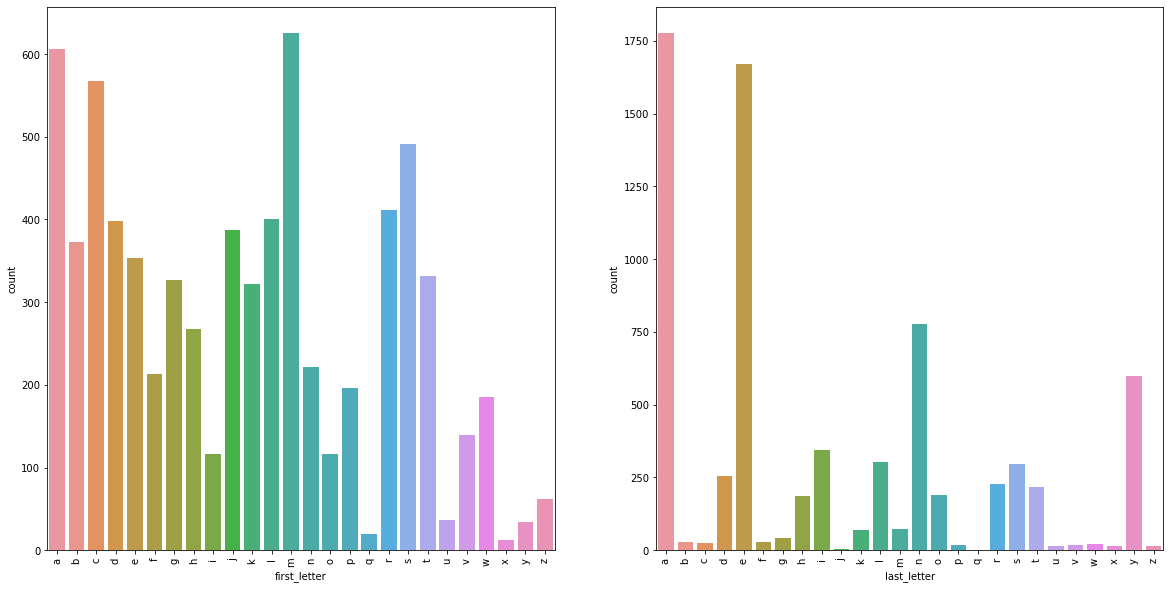

In [10]:
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot,order = list(string.ascii_lowercase))
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

For a better visualization, I will  plot a graph by gender:

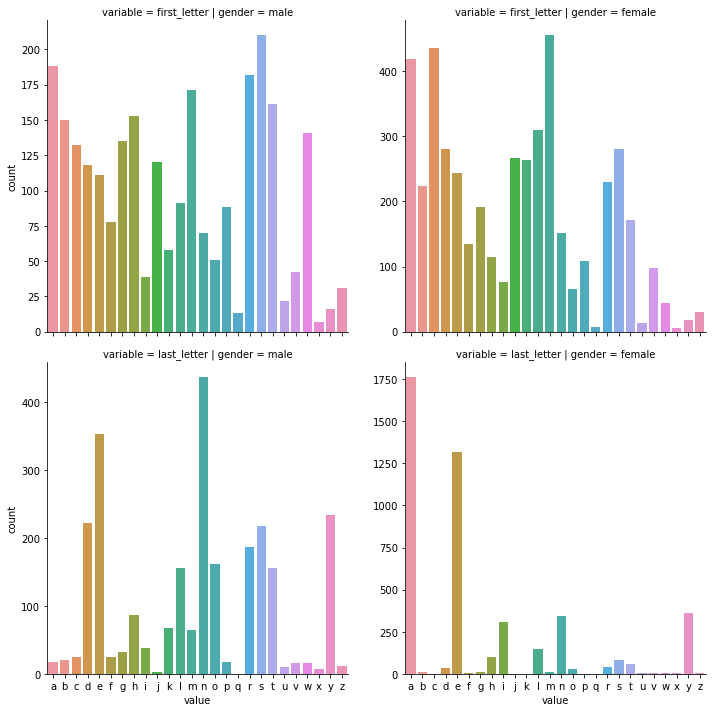

In [11]:
data_melted = pd.melt(data[['gender','first_letter','last_letter']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            order = list(string.ascii_lowercase),
            sharey = False)
plt.show()

According to the graphs, we can use as good predictors: the first and the last letter.

Numerical columns to gender exploration:

<AxesSubplot:xlabel='gender', ylabel='length'>

<AxesSubplot:xlabel='gender', ylabel='vowel_count'>

<AxesSubplot:xlabel='gender', ylabel='consonant_count'>

<AxesSubplot:xlabel='gender', ylabel='syllables'>

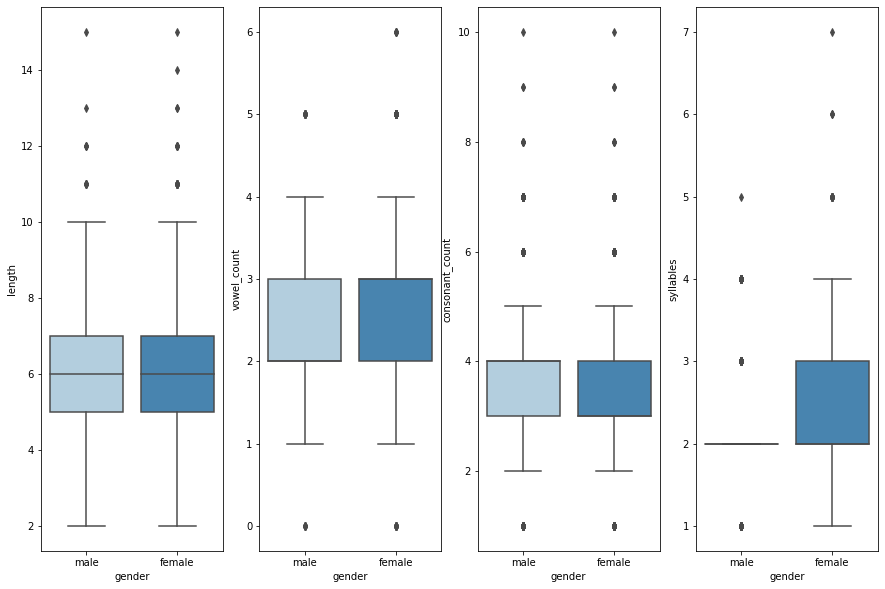

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot, palette="Blues")

Looking at the boxplots above, I can rule out as gender predictors: length, number of vowels, and number of consonants. In the case of syllables, it seems to be a good predictor of gender.

To verify what is seen in the boxplot, I am going to make a conditional count plot for each variable.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


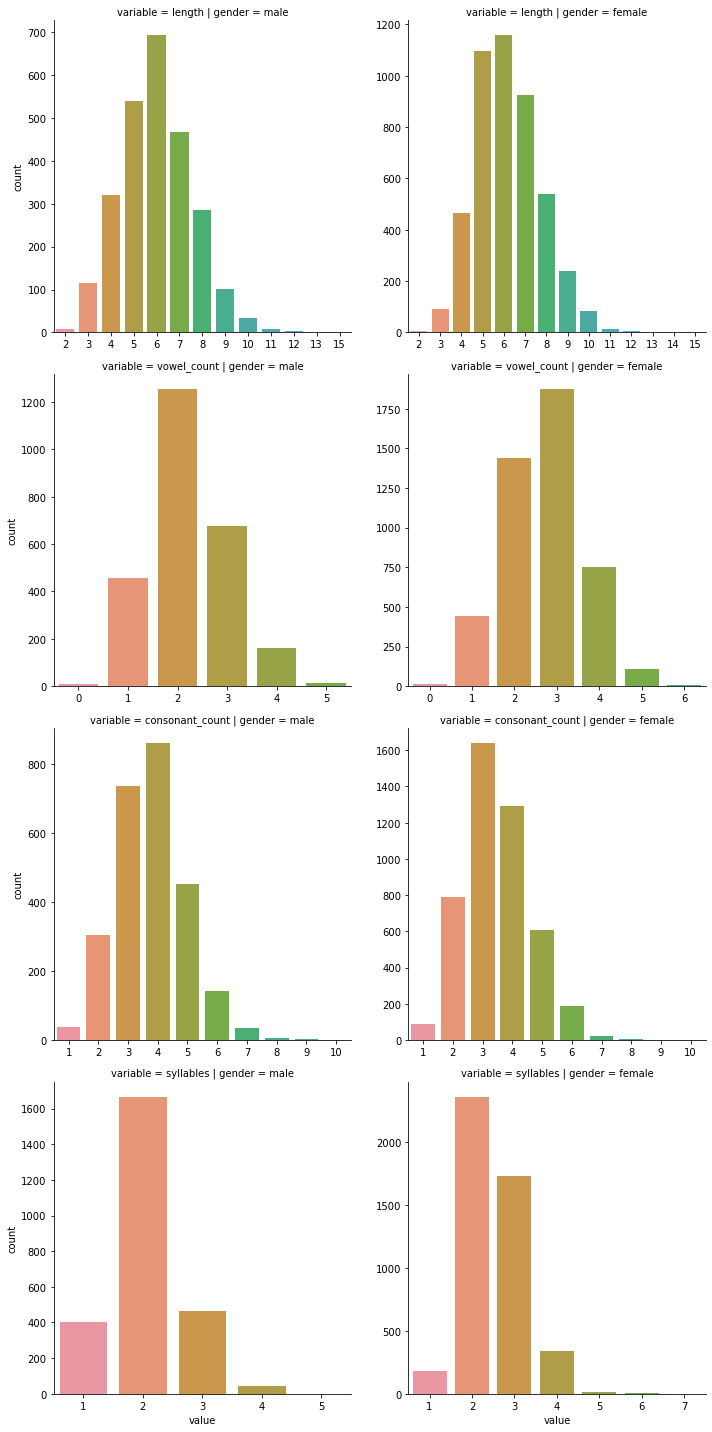

In [30]:
data_melted = pd.melt(data[['gender','length','vowel_count','consonant_count','syllables']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            sharey = False,sharex=False)
plt.show()

Looking at the previous graphs I confirm that we can exclude the length, the number of vowels and the number of consonants as predictors.

### Feature generation function

I'll create the features that we identified as predictors to apply to the name lists. As we refine the model, we will also refine this function to include only the features that seem most relevant to our classifier.

In [79]:
def gender_features(name):
    
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
        
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
        
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

### Apply feature generation function

I'll take the first 500 names for training and development testing. We separate training and development test data. Apply feature generation function.

In [80]:
final_test = all_names[:500]
num_remaining = len(all_names) - 500
training_and_dev_test = all_names[-num_remaining:]

dev_test1 = training_and_dev_test[:500]
training1 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test2 = training_and_dev_test[:500]
training2 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test3 = training_and_dev_test[:500]
training3 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test4 = training_and_dev_test[:500]
training4 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test5 = training_and_dev_test[:500]
training5 = training_and_dev_test[500:]

dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

C:\ProgramData\Anaconda3\lib\site-packages\nltk\tokenize\sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  warnings.warn(


### Apply model - Initial model

I will apply the model. I will use the maximum entropy model.

In [81]:
classifier1v1 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v1 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v1 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v1 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v1 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


Now, we will check the accuracy of our model on the development test data.

In [82]:
nltk.classify.accuracy(classifier1v1, dev_test_features1)
nltk.classify.accuracy(classifier2v1, dev_test_features2)
nltk.classify.accuracy(classifier3v1, dev_test_features3)
nltk.classify.accuracy(classifier4v1, dev_test_features4)
nltk.classify.accuracy(classifier5v1, dev_test_features5)

0.846

0.838

0.816

0.834

0.85

The precision of the model is between 81% and 85%.

I will try to improve the precision, refining the model:

### Refining the model

To improve the accuracy of the model I can add or remove features to better predict the gender.

In [83]:
errors = []

for (name,tag) in dev_test1:
    guess = classifier1v1.classify(gender_features(name))
    if guess != tag:
        errors.append((tag,guess,name))

In [84]:
for (tag,guess,name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:30}'.format(tag,guess,name))

correct=female   guess=male     name=aggy                          
correct=female   guess=male     name=aurel                         
correct=female   guess=male     name=beatriz                       
correct=female   guess=male     name=becky                         
correct=female   guess=male     name=bell                          
correct=female   guess=male     name=betteann                      
correct=female   guess=male     name=bren                          
correct=female   guess=male     name=brittan                       
correct=female   guess=male     name=candis                        
correct=female   guess=male     name=damaris                       
correct=female   guess=male     name=darell                        
correct=female   guess=male     name=daryn                         
correct=female   guess=male     name=dove                          
correct=female   guess=male     name=eryn                          
correct=female   guess=male     name=ester      

In this list we can see which names were incorrectly identified in their gender.

In [85]:
actually_female_guessed_incorrectly = []
actually_male_guessed_incorrectly = []

for (tag,guess,name) in sorted(errors):
    if tag == "female":
        actually_female_guessed_incorrectly.append(name)
    if tag == "male":
        actually_male_guessed_incorrectly.append(name)

In [86]:
print("First letter count errors, actually female then actually male:")
Counter([name[0] for name in actually_female_guessed_incorrectly])
Counter([name[0] for name in actually_male_guessed_incorrectly])
print("First letter vowel count errors:")
Counter([name[0] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[0] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("Last letter count errors:")
Counter([name[-1] for name in actually_female_guessed_incorrectly])
Counter([name[-1] for name in actually_male_guessed_incorrectly])
print("Last letter vowel count errors:")
Counter([name[-1] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[-1] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("List of vowels count errors:")
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_female_guessed_incorrectly])
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_male_guessed_incorrectly])

First letter count errors, actually female then actually male:


Counter({'a': 2,
         'b': 6,
         'c': 1,
         'd': 4,
         'e': 2,
         'g': 1,
         'h': 3,
         'j': 3,
         'm': 1,
         'n': 1,
         'o': 1,
         'r': 3,
         's': 2,
         'w': 1,
         'y': 1})

Counter({'a': 4,
         'b': 2,
         'c': 1,
         'd': 3,
         'f': 1,
         'g': 5,
         'h': 2,
         'i': 1,
         'j': 4,
         'k': 1,
         'm': 4,
         'n': 3,
         'o': 1,
         'p': 2,
         'r': 1,
         's': 4,
         't': 2,
         'v': 3,
         'z': 1})

First letter vowel count errors:


Counter({True: 5, False: 27})

Counter({True: 6, False: 39})

Last letter count errors:


Counter({'y': 6,
         'l': 6,
         'z': 1,
         'n': 7,
         's': 3,
         'e': 1,
         'r': 2,
         'd': 3,
         'h': 2,
         't': 1})

Counter({'c': 1, 'y': 10, 'e': 21, 'n': 7, 'h': 2, 's': 1, 'l': 2, 'a': 1})

Last letter vowel count errors:


Counter({False: 31, True: 1})

Counter({False: 23, True: 22})

List of vowels count errors:


Counter({'a': 4,
         'aeu': 1,
         'aei': 2,
         'e': 7,
         'ae': 3,
         'ai': 4,
         'eo': 3,
         'aeo': 2,
         'ao': 3,
         'i': 1,
         'eu': 1,
         'ei': 1})

Counter({'ai': 3,
         'ae': 5,
         'a': 5,
         'aei': 6,
         'e': 9,
         'ei': 5,
         'eo': 5,
         'eiu': 1,
         '': 2,
         'eio': 2,
         'aiu': 1,
         'aeo': 1})

I can see that in general nouns that were misidentified and are male end in 'e'. I am going to verify the incidence of an 'a' and/or an 'e' in the name in men vs. women in training data.

In [87]:
def vowels(name):
    return "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))

Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "female"])
Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "male"])

Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "female"])
Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "male"])

Counter({True: 2758, False: 1230})

Counter({False: 1100, True: 1126})

Counter({True: 2433, False: 1555})

Counter({True: 1195, False: 1031})

Based on the data, I can see that female names are more likely to contain an 'a' or 'e' than male names.
Let's try adding a "suffix2" feature (last two letters) and see if that improves accuracy.

In [88]:
def gender_features(name):
    
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [89]:
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

In [90]:
classifier1v2 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v2 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v2 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v2 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v2 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [91]:
nltk.classify.accuracy(classifier1v2, dev_test_features1)
nltk.classify.accuracy(classifier2v2, dev_test_features2)
nltk.classify.accuracy(classifier3v2, dev_test_features3)
nltk.classify.accuracy(classifier4v2, dev_test_features4)
nltk.classify.accuracy(classifier5v2, dev_test_features5)

0.848

0.84

0.842

0.834

0.856

The accuracy is 83% and 85%. I only get better in some cases.

I'll try to include the second-to-last letter as a separate variable instead, to see if it improves the request.

In [94]:
def gender_features(name):
  
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    next_to_last_letter = name[-2]
    vowel_last_letter = last_letter in 'aeiou'
    
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'next_to_last_letter': next_to_last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [95]:
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]

In [96]:
classifier1v3 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v3 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v3 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v3 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v3 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [97]:
nltk.classify.accuracy(classifier1v3, dev_test_features1)
nltk.classify.accuracy(classifier2v3, dev_test_features2)
nltk.classify.accuracy(classifier3v3, dev_test_features3)
nltk.classify.accuracy(classifier4v3, dev_test_features4)
nltk.classify.accuracy(classifier5v3, dev_test_features5)

0.862

0.844

0.83

0.838

0.852

In some cases, improve the accuracy a bit if we add the next-to-last letter feature. But it behaves similar to when we use two-letter suffix.

### Final model evaluation

I will verify the accuracy of the model on the final test data. I will use the model that I initially made. Without the two-letter suffix or next-to-last letter features, because these features did not substantially improve the accuracy of the model.

In [98]:
def gender_features(name):
    
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    syllables = len(SSP.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

final_test_features = [(gender_features(name), gender) for name, gender in final_test]

In [99]:
nltk.classify.accuracy(classifier1v1, final_test_features)
nltk.classify.accuracy(classifier2v1, final_test_features)
nltk.classify.accuracy(classifier3v1, final_test_features)
nltk.classify.accuracy(classifier4v1, final_test_features)
nltk.classify.accuracy(classifier5v1, final_test_features)

0.806

0.802

0.798

0.8

0.81

Using the characteristics of the first letter, the first letter of the vowel, the last letter, the last letter of the vowel, the vowels, the consonants, the bigrams and the trigrams, the precision in the final test data is within 80 % and 81%.

I want to know if I had included the unisex names, the precision would have increased or decreased. Initially I think that my model has a higher precision by not having the unisex names included.

I will verify this hypothesis:

In [100]:
((len(males) + len(females))/(len(males) + len(females) + len(unisex)*2))*500
(len(unisex)*2/(len(males) + len(females) + len(unisex)*2))*500

454.0533736153072

45.94662638469285

In total there are approximately 454 names that are unisex. For our list of 500 names there are approximately 46 names. So we are going to include 23 names as male and another 23 names that we are going to include in the list as female.

In [101]:
random.shuffle(unisex)
unisex_as_male = [(name,'male') for name in unisex[:23]]
unisex_as_female = [(name,'female') for name in unisex[23:46]]
final_test = final_test[:454] + unisex_as_male + unisex_as_female

In [102]:
final_test_features = [(gender_features(name), gender) for name, gender in final_test]

nltk.classify.accuracy(classifier1v1, final_test_features)
nltk.classify.accuracy(classifier2v1, final_test_features)
nltk.classify.accuracy(classifier3v1, final_test_features)
nltk.classify.accuracy(classifier4v1, final_test_features)
nltk.classify.accuracy(classifier5v1, final_test_features)

0.786

0.78

0.778

0.782

0.79

The precision of the model decreases: it is 77% to 79% approx.

I'm going to check if the classifier has a bias towards classifying unisex names as male or female.

In [103]:
unisex_as_male_features = [(gender_features(name), 'male') for name in unisex]

nltk.classify.accuracy(classifier1v1, unisex_as_male_features)
nltk.classify.accuracy(classifier2v1, unisex_as_male_features)
nltk.classify.accuracy(classifier3v1, unisex_as_male_features)
nltk.classify.accuracy(classifier4v1, unisex_as_male_features)
nltk.classify.accuracy(classifier5v1, unisex_as_male_features)

0.3452054794520548

0.34794520547945207

0.3315068493150685

0.3452054794520548

0.3506849315068493

The classifier classifies approximately between 33% and 35% as male unisex names. Now I am going to verify how much is the percentage of classification of unisex names as female names.

In [106]:
Counter([gender for name,gender in all_names])

Counter({'male': 2578, 'female': 4636})

In [107]:
2578/(2578 + 4636)

0.35736068755198225

The classifier classifies approximately between 35% as female unisex names. It is similar to the classification of male names.

In conclusion, not using unisex names slightly improves the accuracy percentage of the model. Although it is not a very high difference, it does allow the model to be somewhat more precise when it comes to predicting whether a name is male or female.